In [3]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import matplotlib.pyplot as plt
import re
import pandas as pd
from pathlib import Path
import torch

from fastprogress import master_bar, progress_bar
%config InlineBackend.figure_format ='retina'

In [2]:
import math
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
def gem(x, p=3, eps=1e-5):
    return torch.abs(F.avg_pool2d(x.clamp(min=eps, max=1e4).pow(p), (x.size(-2), x.size(-1))).pow(1./p))
class L2Norm(nn.Module):
    def __init__(self):
        super(L2Norm,self).__init__()
        self.eps = 1e-10
    def forward(self, x):
        norm = torch.sqrt(torch.sum(x * x, dim = 1) + self.eps)
        x= x / norm.unsqueeze(1).expand_as(x)
        return x

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=torch.clamp(self.p, min=0.1), eps=self.eps)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class RingHead(nn.Module):
    def __init__(self, num_classes, feat_dim, in_feat = 1024, r_init =1.5):
        super(RingHead,self).__init__()
        self.eps = 1e-10
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.feature_extractor = nn.Sequential(
                        nn.ReLU(),
                        GeM(3.74), Flatten(),
                        nn.BatchNorm1d(in_feat, eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True),
                        nn.Dropout(p=0.3),
                        nn.Linear(in_features=in_feat, out_features=feat_dim, bias=True),
                        nn.CELU(inplace=True),
                        nn.BatchNorm1d(feat_dim,eps=1e-05, momentum=0.1,
                                                       affine=True, track_running_stats=True))
        
        self.ring =  nn.Parameter(torch.ones(1).cuda()*r_init)
        self.clf = nn.Sequential(nn.Dropout(p=0.5),
                        nn.Linear(in_features=feat_dim, out_features=num_classes, bias=False))
    def forward(self, x):
        feats = self.feature_extractor(x)
        preds = self.clf(feats)
        return preds,feats

class RingGeMNet(nn.Module):
    def __init__(self, new_model, n_classes, in_feats=1024, out_feats=1024):
        super().__init__()
        self.cnn =  new_model.features
        self.head = RingHead(n_classes, out_feats, in_feats)
    def forward(self, x):
        x = self.cnn(x)
        preds,feats = self.head(x)
        return preds,feats

class GeMNet(nn.Module):
    def __init__(self, new_model):
        super().__init__()
        self.cnn =  new_model.features
        self.head = nn.Sequential(nn.ReLU(),
                                  GeM(5.0),
                                  Flatten(),
                                  L2Norm())
    def forward(self, x):
        x = self.cnn(x)
        out = self.head(x)
        return out

In [8]:
EXTRACT_FEATURES = True

In [27]:
import os
from torch.utils.data import Dataset
from PIL import Image

class customDataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    # Chuẩn hóa đường dẫn bằng cách bỏ phần "/kaggle/input/deepfashion1/"
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    # Loại bỏ cấp MEN dư thừa nếu tồn tại
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên (MEN)
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Bỏ qua dòng đầu tiên chứa số lượng và header
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]  # Đường dẫn ảnh từ TXT
            evaluation_status = parts[2]

            # Chỉ lấy các ảnh có evaluation_status = "gallery"
            if evaluation_status == "gallery" and image_name in self.image_paths:
                self.data.append((image_name, self.image_paths[image_name]))  # Lưu tên ảnh và đường dẫn đầy đủ

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None  # Bỏ qua nếu có lỗi khi đọc ảnh
        
        if self.transform:
            image = self.transform(image)
        
        # Trả về ảnh và tên ảnh cùng đường dẫn đầy đủ
        return image, image_name  # Trả về cả ảnh và tên ảnh


In [62]:
from torchvision import transforms
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

gallery_dataset = customDataset(ROOT_DIR, CSV_PATH, transform = transform)

Dataset có tổng cộng 14218 ảnh.
Sample 1:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg


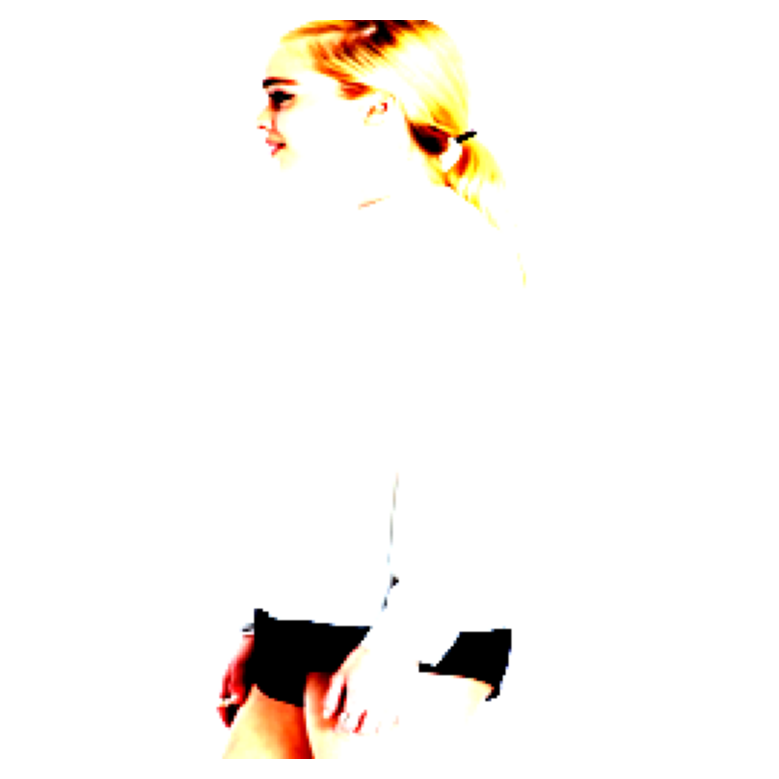

Sample 2:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg


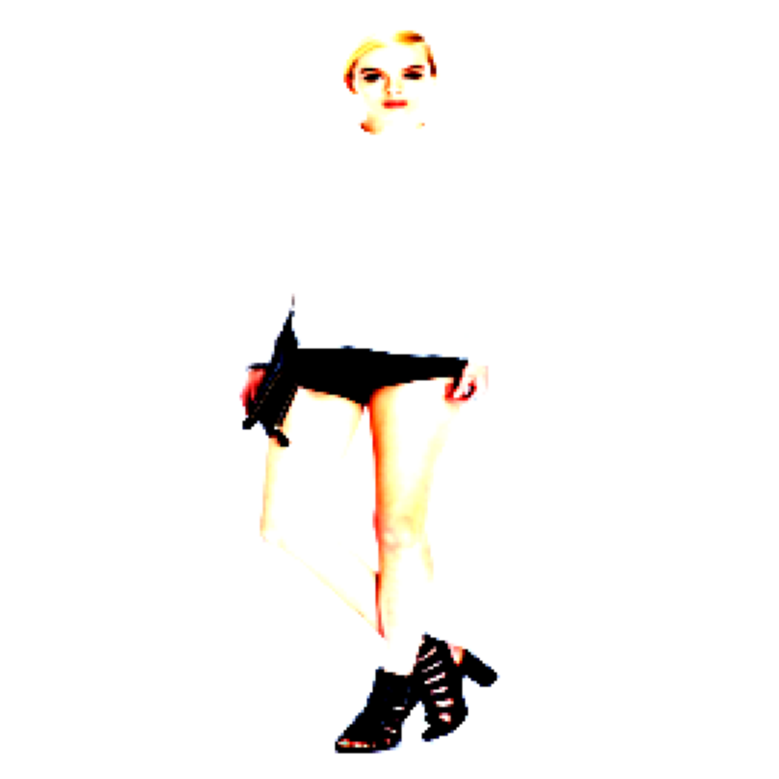

Sample 3:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_2_side.jpg


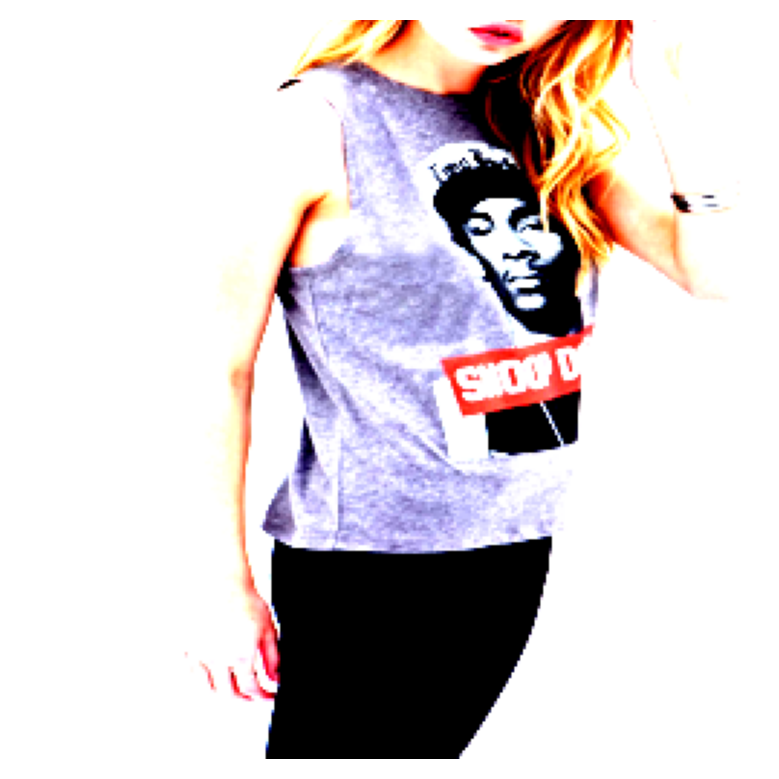

Sample 4:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_4_full.jpg


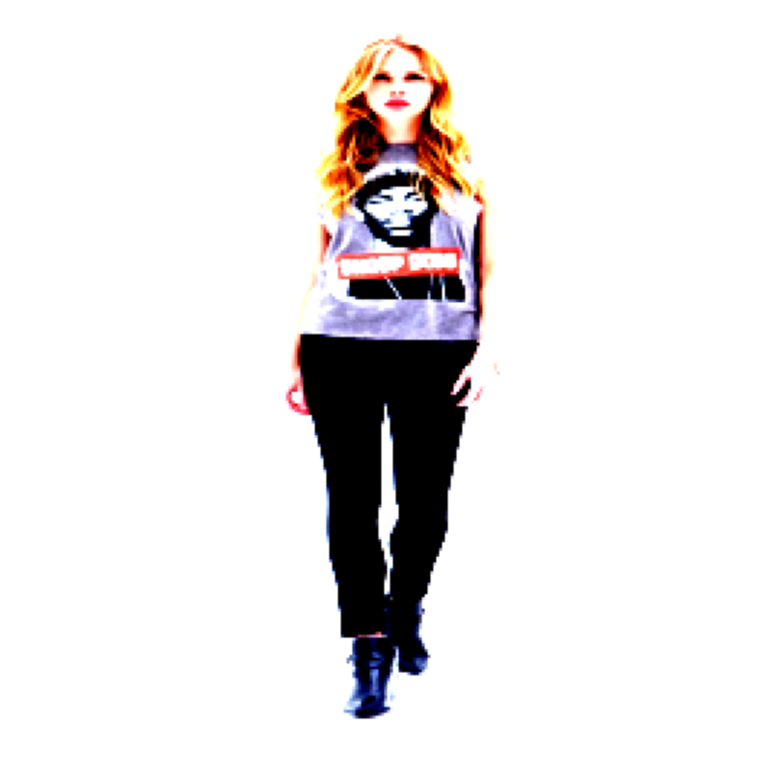

Sample 5:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_6_flat.jpg


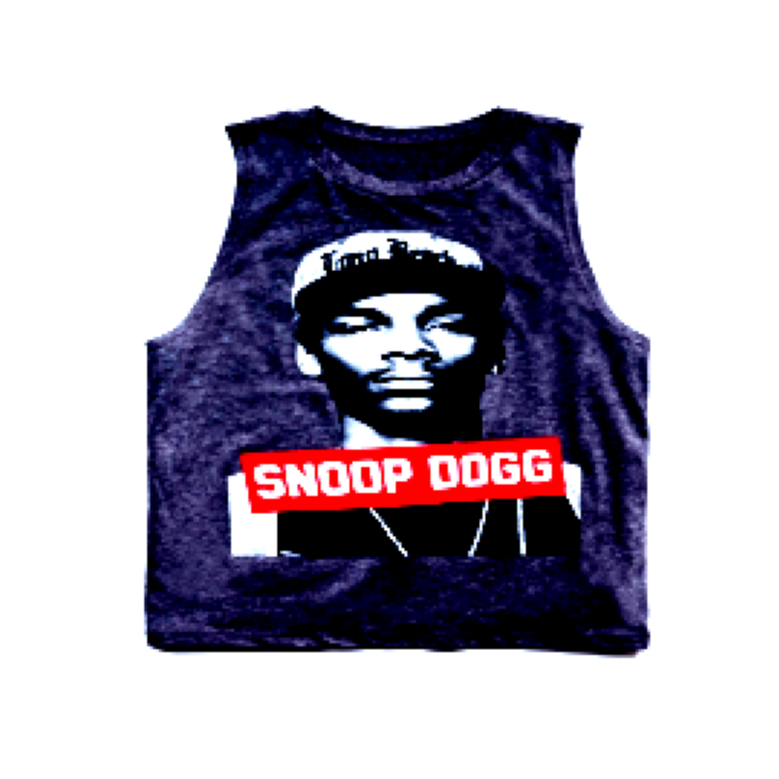

In [63]:
import matplotlib.pyplot as plt

# In ra số lượng ảnh trong dataset
print(f"Dataset có tổng cộng {len(gallery_dataset)} ảnh.")

# Lấy một vài ảnh từ dataset và hiển thị
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, image_name = dataset[i]  # Lấy cả ảnh và tên ảnh
        if image is None:  # Trường hợp có ảnh lỗi
            print(f"Ảnh ở index {i} bị lỗi.")
            continue
        print(f"Sample {i + 1}:")
        print(f"   Tensor size: {image.shape}")
        print(f"   Image Name: {image_name}")  # In ra tên ảnh

        # Hiển thị ảnh
        plt.imshow(image.permute(1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)
        plt.axis("off")
        plt.show()

# Hiển thị 5 mẫu ảnh
show_samples(gallery_dataset)


In [9]:
import torch.nn as nn
if EXTRACT_FEATURES:
    class Extractor(nn.Module):
        def __init__(self):
            super().__init__()
            self.l2norm = L2Norm()
            self.pool = GeM(p=3.0)  # Generalized Mean Pooling
            
        def forward(self, x):
            b, d, ny, nx = x.shape  # b=batch size, d=channels, ny, nx = spatial dimensions
            f0 = self.l2norm(self.pool(x)).view(b, 1, d)  # Normalize and reshape
            return f0


In [10]:
import torchvision.models as models

class CustomModel(nn.Module):
    def __init__(self, backbone_name='resnet152', pretrained=True):
        super(CustomModel, self).__init__()
        # Load backbone model
        backbone = getattr(models, backbone_name)(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # Bỏ lớp cuối
        self.extractor = Extractor()  # Head Extractor
    
    def forward(self, x):
        x = self.backbone(x)   # Feature maps từ backbone
        x = self.extractor(x)  # Áp dụng Extractor để L2-normalize và pool
        return x


In [11]:
model = CustomModel(backbone_name='resnet50', pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [12]:
print(model)

CustomModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [51]:
import os
from torch.utils.data import Dataset
from PIL import Image

class customDataset2(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = {}
        self.data = []

        # Duyệt qua thư mục gốc và lưu đường dẫn ảnh
        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(".jpg"):
                    # Chuẩn hóa đường dẫn bằng cách bỏ phần "/kaggle/input/deepfashion1/"
                    relative_path = os.path.relpath(os.path.join(root, file), root_dir)
                    # Loại bỏ cấp MEN dư thừa nếu tồn tại
                    corrected_path = "/".join(relative_path.split("/")[1:])  # Bỏ cấp đầu tiên (MEN)
                    self.image_paths[corrected_path] = os.path.join(root, file)

        # Đọc file txt chứa thông tin image_name và evaluation_status
        with open(txt_path, "r") as f:
            lines = f.readlines()

        # Bỏ qua dòng đầu tiên chứa số lượng và header
        for line in lines[2:]:
            parts = line.strip().split()
            image_name = parts[0]  # Đường dẫn ảnh từ TXT
            evaluation_status = parts[2]

            # Chỉ lấy các ảnh có evaluation_status = "gallery"
            if evaluation_status == "query" and image_name in self.image_paths:
                self.data.append((image_name, self.image_paths[image_name]))  # Lưu tên ảnh và đường dẫn đầy đủ

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, img_path = self.data[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None  # Bỏ qua nếu có lỗi khi đọc ảnh
        
        if self.transform:
            image = self.transform(image)
        
        # Trả về ảnh và tên ảnh cùng đường dẫn đầy đủ
        return image, image_name  # Trả về cả ảnh và tên ảnh


In [68]:
from torchvision import transforms
# Đường dẫn đến dữ liệu
ROOT_DIR = "/kaggle/input/deepfashion1"  # Thay bằng thư mục chứa ảnh
CSV_PATH = "/kaggle/input/deepfashion1/updated_list_eval_partition.txt"  # Thay bằng đường dẫn file CSV

# Transform: Resize và Normalize
transform = transforms.Compose([
    transforms.Resize((256, 256)),                    # Resize ảnh
    transforms.ToTensor(),                         # Chuyển đổi ảnh thành tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize theo ImageNet Stats
])

query_dataset = customDataset2(ROOT_DIR, CSV_PATH, transform = transform)

Dataset có tổng cộng 14218 ảnh.
Sample 1:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg


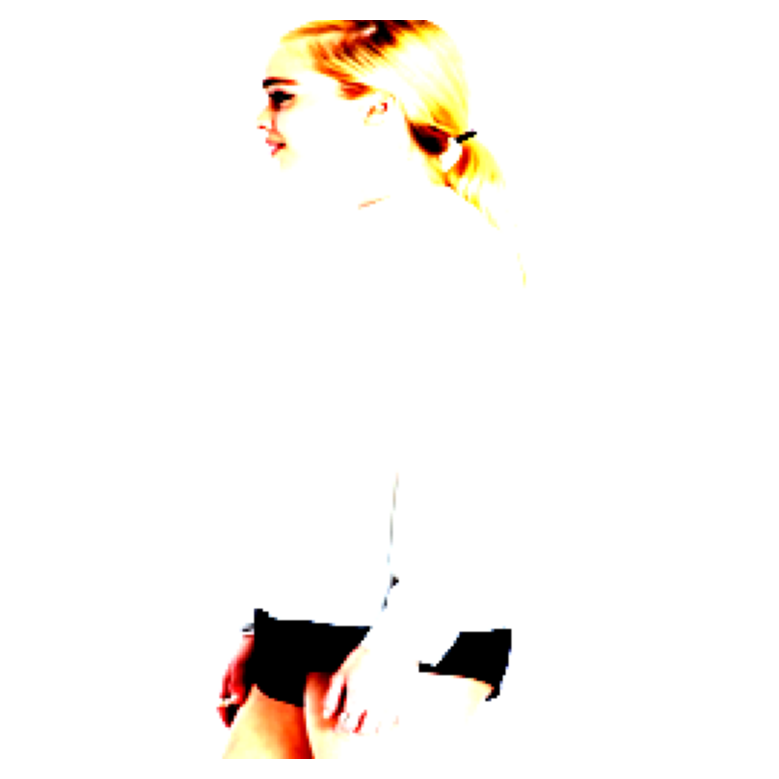

Sample 2:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg


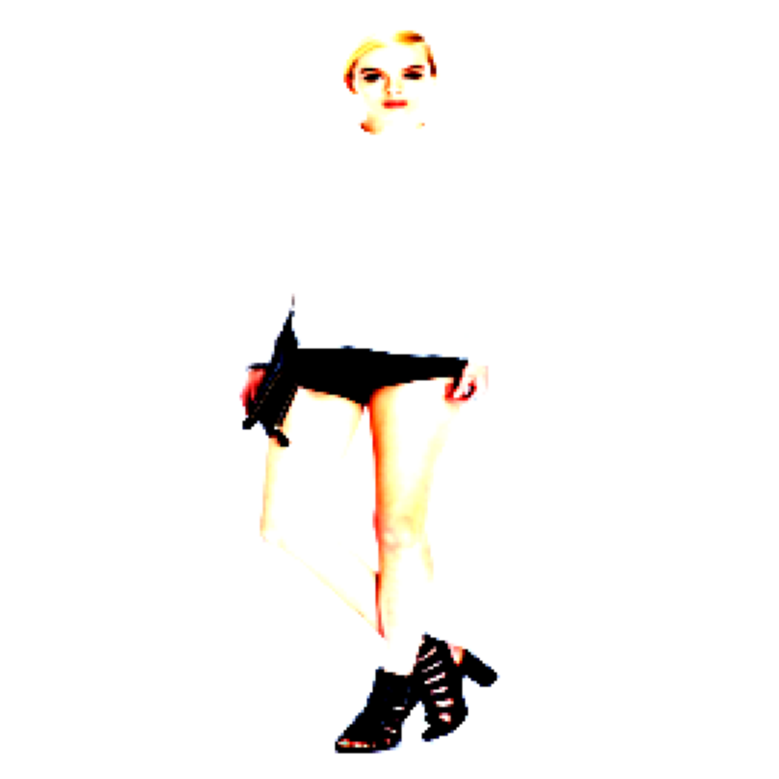

Sample 3:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_2_side.jpg


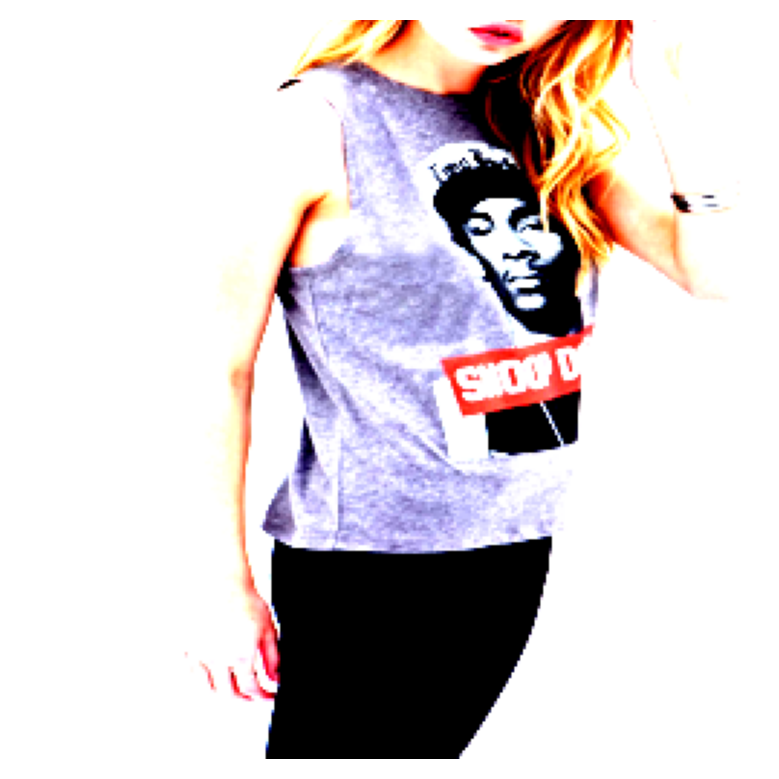

Sample 4:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_4_full.jpg


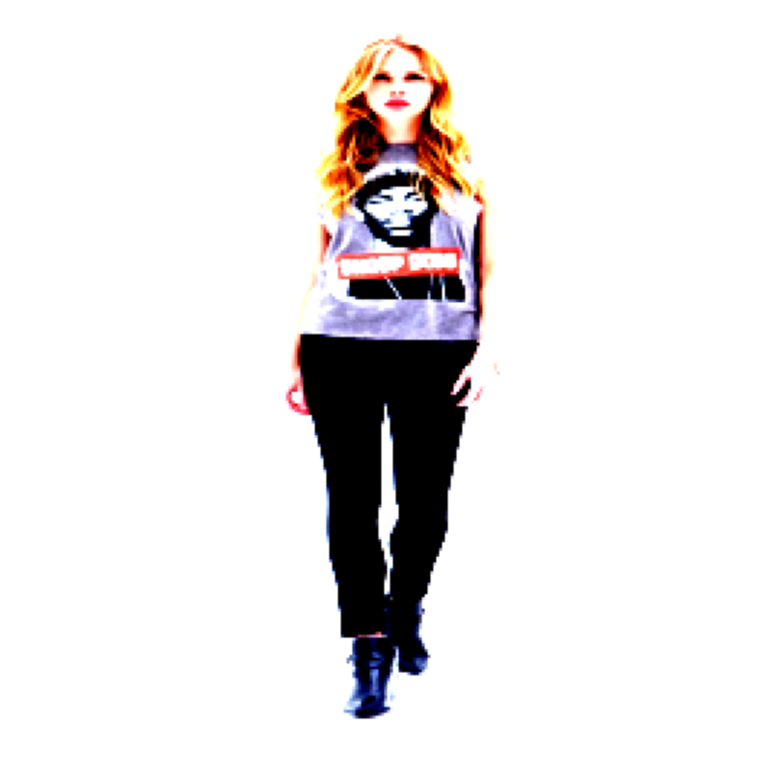

Sample 5:
   Tensor size: torch.Size([3, 256, 256])
   Image Name: WOMEN/Tees_Tanks/id_00000007/01_6_flat.jpg


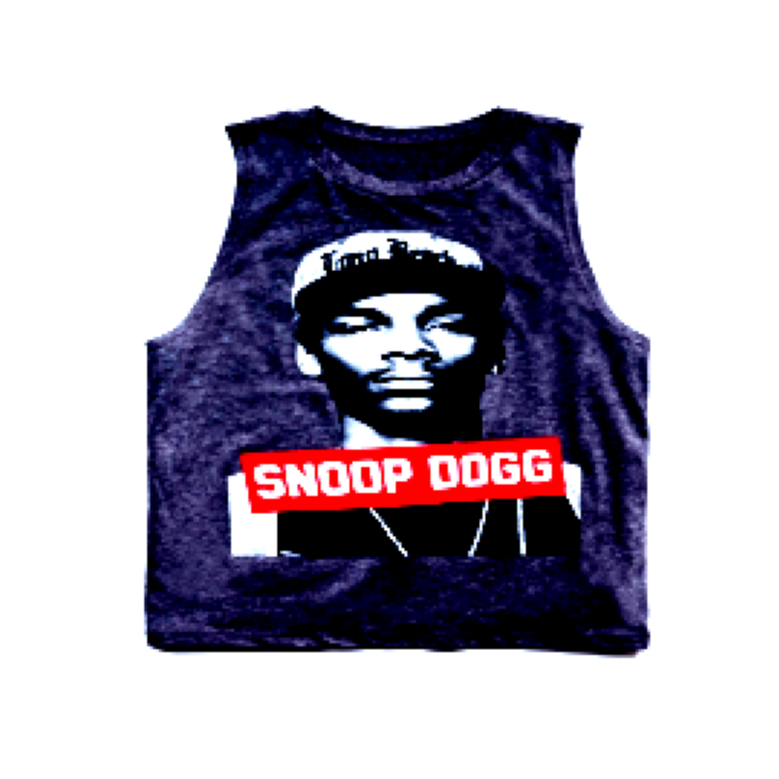

In [70]:
import matplotlib.pyplot as plt

# In ra số lượng ảnh trong dataset
print(f"Dataset có tổng cộng {len(query_dataset)} ảnh.")

# Lấy một vài ảnh từ dataset và hiển thị
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, image_name = dataset[i]  # Lấy cả ảnh và tên ảnh
        if image is None:  # Trường hợp có ảnh lỗi
            print(f"Ảnh ở index {i} bị lỗi.")
            continue
        print(f"Sample {i + 1}:")
        print(f"   Tensor size: {image.shape}")
        print(f"   Image Name: {image_name}")  # In ra tên ảnh

        # Hiển thị ảnh
        plt.imshow(image.permute(1, 2, 0))  # Chuyển đổi từ (C, H, W) -> (H, W, C)
        plt.axis("off")
        plt.show()

# Hiển thị 5 mẫu ảnh
show_samples(query_dataset)


In [33]:
def extract_vectors_batched(dataloader, model, flip=False, device="cuda"):
    """
    Trích xuất vector đặc trưng từ mô hình theo từng batch.

    Args:
        dataloader: DataLoader PyTorch chứa dataset (images).
        model: Mô hình PyTorch để trích xuất vector.
        flip: Có áp dụng flipping để tăng cường dữ liệu hay không.
        device: Thiết bị thực thi ("cuda" hoặc "cpu").

    Returns:
        Tensor chứa vector đặc trưng cho tất cả ảnh, danh sách tên ảnh.
    """
    model.to(device)
    model.eval()

    n_flip = 2 if flip else 1  # Nếu flip, số ảnh mỗi batch sẽ gấp đôi
    n_img = len(dataloader.dataset) * n_flip  # Tổng số ảnh (bao gồm flipping nếu có)
    bs = dataloader.batch_size
    vectors = None  # Khởi tạo vector kết quả
    image_names = []  # Danh sách tên ảnh

    with torch.no_grad():
        for idx, (img_batch, img_names) in enumerate(tqdm(dataloader, desc="Extracting Features")):
            img_batch = img_batch.to(device)
            st = idx * bs * n_flip
            fin = min((idx + 1) * bs * n_flip, n_img)

            # Xử lý flipping nếu cần
            if flip:
                img_batch = torch.cat((img_batch, torch.flip(img_batch, dims=[3])), dim=0)  # Flip theo chiều ngang

            # Forward qua model
            out = model(img_batch).cpu()  # Chuyển output về CPU

            # Khởi tạo vector lưu kết quả trong lần lặp đầu tiên
            if vectors is None:
                vectors = torch.zeros(n_img, *out.shape[1:])

            # Ghi vector output vào vị trí tương ứng
            if flip:
                n = fin - st
                vectors[st:fin:2, ...] = out[:n // 2, ...]      # Ảnh gốc
                vectors[st + 1:fin + 1:2, ...] = out[n // 2:, ...]  # Ảnh flip
                image_names.extend([name for name in img_names] * 2)  # Lưu tên ảnh cho cả ảnh gốc và ảnh flip
            else:
                vectors[st:fin, ...] = out
                image_names.extend(img_names)  # Lưu tên ảnh

    return vectors, image_names

In [35]:
import os
import torch

# Hàm trích xuất đặc trưng và lưu cache
def extract_and_cache_features(dataloader, model, feature_file, flip=False, device="cuda"):
    """
    Trích xuất và lưu các vector đặc trưng từ dataloader.

    Args:
        dataloader: PyTorch DataLoader.
        model: Mô hình trích xuất đặc trưng.
        feature_file: Tên file để lưu/tải vector đặc trưng.
        flip: Áp dụng flipping dữ liệu nếu True.
        device: Thiết bị thực thi ("cuda" hoặc "cpu").
    Returns:
        Tensor các vector đặc trưng.
    """
    p_flip = 'flip' if flip else ''  # Tạo tên file dựa trên flip

    # Kiểm tra file đã tồn tại hay chưa
    if os.path.exists(feature_file):
        print(f"Loading {feature_file} from disk...", end=" ")
        features = torch.load(feature_file)
        print("OK")
    else:
        print(f"Failed to load {feature_file}. Extracting features...")
        features = extract_vectors_batched(dataloader, model, flip=flip, device=device)
        torch.save(features, feature_file)
        print(f"Features saved to {feature_file}.")
    return features

# Đường dẫn lưu các file đặc trưng
# Đường dẫn lưu file trong Kaggle
output_dir = "/kaggle/working/"  # Lưu file tạm thời trong Kaggle Notebook

# Tạo đường dẫn đầy đủ cho file cache
query_feature_file = os.path.join(output_dir, "query_flip.pt")
train_feature_file = os.path.join(output_dir, "train_flip.pt")

# Model trích xuất đặc trưng
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tạo DataLoader cho query và train datasets
query_dataloader = DataLoader(query_dataset, batch_size=16, shuffle=False, num_workers=4)
gallery_dataloader = DataLoader(gallery_dataset, batch_size=16, shuffle=False, num_workers=4)


# Trích xuất hoặc load các vector đặc trưng
query_features, query_image_names = extract_vectors_batched(gallery_dataloader, model, flip=True, device=device)
gallery_features, gallery_image_names = extract_vectors_batched(gallery_dataloader, model, flip=True, device=device)

# In kết quả
print(f"Gallery features shape: {gallery_features.shape}")
print(f"Gallery image names: {gallery_image_names[:5]}")  # Hiển thị tên của 5 ảnh đầu tiên


Extracting Features: 100%|██████████| 789/789 [01:37<00:00,  8.10it/s]

Gallery features shape: torch.Size([25224, 1, 2048])
Gallery image names: ['WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_3_back.jpg', 'WOMEN/Dresses/id_00000008/02_3_back.jpg']


In [36]:
query_features, gallery_features

(tensor([[[0.0136, 0.0244, 0.0509,  ..., 0.0069, 0.0155, 0.0304]],
 
         [[0.0101, 0.0227, 0.0550,  ..., 0.0083, 0.0141, 0.0249]],
 
         [[0.0048, 0.0174, 0.0394,  ..., 0.0224, 0.0146, 0.0244]],
 
         ...,
 
         [[0.0190, 0.0375, 0.0425,  ..., 0.0057, 0.0142, 0.0059]],
 
         [[0.0042, 0.0181, 0.0502,  ..., 0.0082, 0.0117, 0.0144]],
 
         [[0.0063, 0.0150, 0.0483,  ..., 0.0061, 0.0174, 0.0141]]]),
 tensor([[[0.0136, 0.0244, 0.0509,  ..., 0.0069, 0.0155, 0.0304]],
 
         [[0.0101, 0.0227, 0.0550,  ..., 0.0083, 0.0141, 0.0249]],
 
         [[0.0048, 0.0174, 0.0394,  ..., 0.0224, 0.0146, 0.0244]],
 
         ...,
 
         [[0.0190, 0.0375, 0.0425,  ..., 0.0057, 0.0142, 0.0059]],
 
         [[0.0042, 0.0181, 0.0502,  ..., 0.0082, 0.0117, 0.0144]],
 
         [[0.0063, 0.0150, 0.0483,  ..., 0.0061, 0.0174, 0.0141]]]))

In [24]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.5 MB/s eta 0:00:00:00:0100:01


In [71]:
import faiss
import itertools
from pathlib import Path

# Hàm flatten dùng để làm phẳng danh sách 2 chiều
def flatten(list2d):
    return list(itertools.chain(*list2d))

# Lấy đường dẫn ảnh từ dataset (không rút gọn tên ảnh)
query_fnames = flatten([[image_name,image_name] for _, image_name in query_dataset])
index_fnames = flatten([[image_name,image_name] for _, image_name in gallery_dataset])

print("Query file paths:", query_fnames[:5])   # In ra 5 đường dẫn đầu tiên trong query_fnames
print("Index file paths:", index_fnames[:5])   # In ra 5 đường dẫn đầu tiên trong index_fnames


Query file paths: ['WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_2_side.jpg']
Index file paths: ['WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg', 'WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg', 'WOMEN/Tees_Tanks/id_00000007/01_2_side.jpg']


In [81]:
import numpy as np
def t_pcawhitenlearn(X):

    N = X.shape[0]

    # Learning PCA w/o annotations
    m = X.mean(dim=0, keepdim=True)
    Xc = X - m
    Xcov = Xc.t() @ Xc
    Xcov = (Xcov + Xcov.t()) / (2*N)
    eigval, eigvec = torch.symeig(Xcov,eigenvectors=True)
    order = eigval.argsort(descending=True)
    eigval = eigval[order]
    eigvec = eigvec[:, order]

    P = torch.inverse(torch.sqrt(torch.diag(eigval))) @ eigvec.t()

    return m, P

def t_whitenapply(X, m, P, dimensions=None):

    if not dimensions: dimensions = P.shape[1]

    X = (X-m) @ P[:,:dimensions]
    X = X / (torch.norm(X, dim=1, keepdim=True) + 1e-6)
    return X

def get_idxs_and_dists(_query_features, _index_features, index_type='', BS = 32):

    if False:
        index_transforms = []
        for index_transform in index_type.split(','):
            m = re.match(r'PCAW(\d+)?', index_transform)
            if m is not None:
                dimensions = int(m[1]) if m[1] is not None else _index_features.shape[-1]
                print(f"Applying {dimensions} PCA, Whitening and L2Norm...", end="")
                m, P = t_pcawhitenlearn(_index_features)
                _index_features = t_whitenapply(_index_features, m, P,dimensions=dimensions).unsqueeze(1)
                _query_features = t_whitenapply(_query_features, m, P,dimensions=dimensions).unsqueeze(1)
                print("done")

            elif index_transform not in ['L2norm']: index_transforms.append(index_transform)

        index_type = ','.join(index_transforms)
        print(index_type)
    else:
         _index_features = _index_features.unsqueeze(1)
         _query_features = _query_features.unsqueeze(1)

    if isinstance(_query_features, torch.Tensor): query_features = _query_features.numpy()
    if isinstance(_index_features, torch.Tensor): index_features = _index_features.numpy()
    max_hits = 20

    n_patches = query_features.shape[1]
    n_queries = query_features.shape[0]

    print(query_features.shape, index_features.shape, n_queries, n_patches)

    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.device = 0
    res = faiss.StandardGpuResources()
    co = faiss.GpuMultipleClonerOptions()
    co.shard=True
    co.shard_type=1
    co.useFloat16=False
    index_features = index_features.squeeze(1)  # Remove the extra singleton dimension
    query_features = query_features.squeeze(1)  # Remove the extra singleton dimension
    print(index_features.shape)  # Should print (num_samples, num_dimensions)
    print(query_features.shape)  # Should print (num_queries, num_dimensions)
    _index = faiss.index_factory(index_features.shape[1], index_type)#, faiss.METRIC_INNER_PRODUCT)
    try:
        index = _index #faiss.index_cpu_to_all_gpus(_index,co=co) #
        print("Index in GPU")
    except:
        index = _index
        print("Index in CPU")
    print("Training index...", end="")
    index.train(index_features)
    print("done")
    print("Adding features to index...", end="")
    index.add(index_features)
    print("done")
    out_dists = np.zeros((len(query_features), max_hits), dtype=np.float32)
    out_idxs  = np.zeros((len(query_features), max_hits), dtype=np.int32)
    NUM_QUERY = len (query_features)
    for ind in progress_bar(range(0, len(query_features), BS)):
        fin = ind+BS
        if fin > NUM_QUERY: fin = NUM_QUERY
        q_descs = query_features[ind:fin]
        D, I = index.search(q_descs, max_hits)
        out_dists[ind:fin] = D
        out_idxs[ind:fin] = I // n_patches
    return out_idxs, out_dists

In [73]:
faiss.omp_get_max_threads()

2

In [79]:
# Squeeze out the singleton dimensions
gallery_features = gallery_features.squeeze(1).squeeze(1)  # Remove the extra singleton dimensions
query_features = query_features.squeeze(1).squeeze(1)  # Remove the extra singleton dimensions

print("Shape of index_features:", gallery_features.shape)  # Should print (25224, 2048)
print("Shape of query_features:", query_features.shape)  # Should print (num_queries, 2048)

Shape of index_features: torch.Size([25224, 2048])
Shape of query_features: torch.Size([25224, 2048])


In [82]:
#faiss.omp_set_num_threads(31)
index_type=f"PCAW{query_features.shape[-1]},L2norm,Flat"
#index_type="PCAW512,L2norm,IVF4096,PQ16"
#index_type="Flat"

#out_idxs, out_dists = get_idxs_and_dists(
#    torch.cat((query_features[0],query_features[1]),dim=-1).squeeze(1),
#    torch.cat((index_features[0],index_features[1]),dim=-1).squeeze(1), BS = 32*4, index_type=index_type)
out_idxs, out_dists = get_idxs_and_dists(
    query_features,
    gallery_features, index_type=index_type, BS = 32*4 )

(25224, 1, 2048) (25224, 1, 2048) 25224 1
(25224, 2048)
(25224, 2048)
Index in GPU
Training index...done
Adding features to index...done


In [83]:
np.sort(out_dists.reshape((-1,int(out_idxs.shape[1]*1))), axis=1)

array([[0.0000000e+00, 5.7905841e-01, 1.6580513e+00, ..., 1.7820768e+00,
        1.7825688e+00, 1.7923417e+00],
       [0.0000000e+00, 5.7905817e-01, 1.5862628e+00, ..., 1.7849877e+00,
        1.7852316e+00, 1.7886796e+00],
       [0.0000000e+00, 4.6967959e-01, 1.5005548e+00, ..., 1.7965703e+00,
        1.7983804e+00, 1.7994027e+00],
       ...,
       [8.6770070e-12, 9.2340481e-01, 1.6138434e+00, ..., 1.8160491e+00,
        1.8161223e+00, 1.8168571e+00],
       [8.0836969e-12, 6.9062912e-01, 1.7992773e+00, ..., 1.8424827e+00,
        1.8434325e+00, 1.8438774e+00],
       [7.9770990e-12, 6.9062883e-01, 1.7809968e+00, ..., 1.8456427e+00,
        1.8466130e+00, 1.8511373e+00]], dtype=float32)

In [84]:
np.save(f'idx.npy',  out_idxs)
np.save(f'dist.npy', out_dists)

In [141]:
import os
import csv

# Đọc file TXT chứa thông tin ảnh
txt_path = '/kaggle/input/deepfashion1/updated_list_eval_partition.txt'  # Đường dẫn tới file TXT
root_dir = '/kaggle/input/deepfashion1/images'  # Đường dẫn tới thư mục chứa ảnh (nếu cần)

# Tạo danh sách chứa các ảnh có evaluation_status = "query"
data = []

with open(txt_path, 'r') as f:
    lines = f.readlines()

# Bỏ qua dòng đầu tiên và header
for line in lines[2:]:
    parts = line.strip().split()
    image_name = parts[0]  # Tên ảnh
    evaluation_status = parts[2]  # Trạng thái đánh giá

    # Kiểm tra nếu evaluation_status = "query"
    if evaluation_status == "query":
        # Thêm image_name vào danh sách
        data.append(image_name)

# Đặt tên file và lưu query.csv
output_file = '/kaggle/working/query.csv'  # Đường dẫn nơi file sẽ được lưu

with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['images']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Ghi header
    writer.writeheader()

    # Ghi từng dòng dữ liệu
    for image_name in data:
        writer.writerow({'images': image_name})

print(f"query.csv đã được tạo thành công và lưu tại {output_file}.")


query.csv đã được tạo thành công và lưu tại /kaggle/working/query.csv.


In [142]:
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('query.csv')
sample_df['images'] = ''

In [143]:
out_idxs[0]//2, out_idxs[1]//2

(array([    0,     0,     1,  8052,  1055,  7973,  3432,  8647,  1055,
         3624,     1,  3852,  3624,  3432,  1054,  6106,  2547, 12449,
         7973,  8463], dtype=int32),
 array([    0,     0,     1,  1055,     1,  8052,  7973,  7973,  3624,
         1054,  3624,  1055,  9941,  3432, 12249,  1056, 12249,  3852,
         3432,  3852], dtype=int32))

In [144]:
i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]]//2)

i = 2
idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
dst = np.concatenate([out_dists[i],out_dists[i+1]], axis=0)
u_idx = np.unique(idx,return_index=True)[1]
i_dst = dst[u_idx]
o_dst =np.argsort(i_dst)
print(idx, o_dst, i_dst)
print(idx[u_idx[o_dst]])

[    2     3 20600 20601     1 15947  2112  7738 12020  2111 13922   120
     0 10234 24819 15946 12021 18163 22036 15746     3     2 20601 20600
  2111     1     0  2112 15947  2110 24819 10234  2921 15946  7738   120
 23478 12020 10235 22036] [ 2  3 19 20  1 17  7  9 12  6  5 14  4  0  8 10 23 22 16 13 11 18 21 15] [1.7684971 1.6697676 0.        0.4696796 1.7673672 1.7381768 1.7249169
 1.713268  1.7703774 1.7140007 1.7770163 1.7930545 1.7167959 1.791597
 1.7543256 1.7994027 1.7908483 1.6975113 1.7965703 1.5005548 1.5127425
 1.7983804 1.7901787 1.7780418]
[    1     1 10300 10300     0  7973  1056  3869  6010  1055  1055  6961
    60     0  1460  5117 12409 11739  7973  6010  5117  9081 11018  7873]
[    1     1 10300 10300     0  7973  1056  3869  6010  1055  6961    60
     0  5117 12409  7973  6010  9081 11018  7873     1     1 10300 10300
  1055     0     0  1056  7973  1055 12409  5117  1460  7973  3869    60
 11739  6010  5117 11018] [ 1 13  0 11  4  6  8  3  9  2  5  7 16 15 12

In [145]:
sub = {}
for i, query_fname in progress_bar(enumerate(query_fnames), total=len(query_fnames)):
    if i % 2: continue
    
    # Kiểm tra để tránh vượt quá chỉ mục
    if i + 1 >= len(out_idxs):  # Nếu i+1 vượt quá kích thước mảng, bỏ qua
        continue
    
    idx = np.concatenate([out_idxs[i], out_idxs[i+1]], axis=0)//2
    dst = np.concatenate([out_dists[i], out_dists[i+1]], axis=0)
    
    u_idx = np.unique(idx, return_index=True)[1]
    i_dst = dst[u_idx]
    o_dst = np.argsort(i_dst)
    _out_idxs = idx[u_idx[o_dst]]

    ids = [index_fnames[x*2] for x in _out_idxs[:10]]
    sub[query_fname] = ' '.join(ids)


In [146]:
sub_df = pd.DataFrame({'id' : list(sub.keys()), 'images':list(sub.values())})
sub_df = pd.concat([sub_df, sample_df]).drop_duplicates(subset=['id'])
sub_df.to_csv(sub_fname, index=False)

In [147]:
sub_df.iloc[:8]

id  \
0  WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg   
1  WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg   
2      WOMEN/Tees_Tanks/id_00000007/01_2_side.jpg   
3      WOMEN/Tees_Tanks/id_00000007/01_4_full.jpg   
4      WOMEN/Tees_Tanks/id_00000007/01_6_flat.jpg   
5   WOMEN/Dresses/id_00000008/02_7_additional.jpg   
6         WOMEN/Dresses/id_00000011/02_2_side.jpg   
7         WOMEN/Dresses/id_00000011/02_3_back.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                       images  
0                WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg WOMEN/Sweaters/id_00004524/03_3_back.jpg MEN/Tees_Tanks/id_00000642/02_4_full.jpg WOMEN/Tees_Tanks/id_00004478/05_4_full.jpg WOMEN/Skirts/id_00001983/05_7_additional.jpg MEN/Tees_Tanks/id_00004798/06_3_back.jpg WOMEN/Jackets_Coats/id_00005591/02_1_front.jpg WOMEN/Shorts/id_00002104/02_1_front.jpg WOMEN/Blouses_Shirts/id_00006945/04_7_additional.jpg  
1     WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg WOMEN/Dresses/id_00005768/13_1_front.jpg WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg WOMEN/Tees_Tanks/id_00004478/05_4_full.jpg MEN/Tees_Tanks/id_00000642/02_7_additional.jpg WOMEN/Dresses/id_00002190/02_4_full.jpg WOMEN/Rompers_Jumpsuits/id_00003395/02_7_additional.jpg MEN/Tees_Tanks/id_00000642/02_4_full.jpg MEN/Tees_Tanks/id_00003903/01_4_full.jpg WOMEN/Blouses_Shirts/id_00000040/03_7_additional.jpg  
2                     WOMEN/Tees_Tanks/id_00000007/01_2_side.jpg WOMEN/Dresses/id_00004681/05_1_front.jpg WOMEN/Sweatshirts_Hoodies/id_00001249/11_2_side.jpg MEN/Tees_Tanks/id_00000390/15_2_side.jpg WOMEN/Tees_Tanks/id_00004870/02_1_front.jpg WOMEN/Pants/id_00003919/04_7_additional.jpg WOMEN/Dresses/id_00006022/02_1_front.jpg MEN/Shorts/id_00001682/01_7_additional.jpg WOMEN/Blouses_Shirts/id_00002366/01_2_side.jpg WOMEN/Tees_Tanks/id_00002112/08_1_front.jpg  
3                          WOMEN/Tees_Tanks/id_00000007/01_4_full.jpg WOMEN/Dresses/id_00006555/03_3_back.jpg MEN/Sweaters/id_00001088/01_7_additional.jpg WOMEN/Blouses_Shirts/id_00006927/02_3_back.jpg WOMEN/Sweaters/id_00002726/03_4_full.jpg WOMEN/Dresses/id_00000585/01_4_full.jpg WOMEN/Shorts/id_00004037/01_3_back.jpg WOMEN/Skirts/id_00001568/02_4_full.jpg WOMEN/Blouses_Shirts/id_00004470/03_7_additional.jpg WOMEN/Blouses_Shirts/id_00004893/03_1_front.jpg  
4  WOMEN/Tees_Tanks/id_00000007/01_6_flat.jpg WOMEN/Dresses/id_00003735/02_1_front.jpg WOMEN/Sweaters/id_00005099/05_7_additional.jpg WOMEN/Rompers_Jumpsuits/id_00004624/02_7_additional.jpg WOMEN/Jackets_Coats/id_00000635/02_3_back.jpg WOMEN/Sweatshirts_Hoodies/id_00000986/01_4_full.jpg WOMEN/Blouses_Shirts/id_00003364/02_3_back.jpg WOMEN/Shorts/id_00002465/05_2_side.jpg WOMEN/Shorts/id_00006962/02_3_back.jpg WOMEN/Tees_Tanks/id_00006631/01_7_additional.jpg  
5         WOMEN/Dresses/id_00000008/02_7_additional.jpg WOMEN/Shorts/id_00001694/02_2_side.jpg WOMEN/Tees_Tanks/id_00005096/02_7_additional.jpg MEN/Sweaters/id_00005021/05_7_additional.jpg WOMEN/Blouses_Shirts/id_00003220/07_1_front.jpg WOMEN/Tees_Tanks/id_00002824/03_4_full.jpg WOMEN/Shorts/id_00005369/04_7_additional.jpg WOMEN/Cardigans/id_00005191/01_1_front.jpg WOMEN/Dresses/id_00003146/02_7_additional.jpg WOMEN/Blouses_Shirts/id_00002763/02_1_front.jpg  
6                   WOMEN/Dresses/id_00000011/02_2_side.jpg WOMEN/Dresses/id_00000011/02_3_back.jpg MEN/Shirts_Polos/id_00005811/01_7_additional.jpg MEN/Tees_Tanks/id_00000296/04_2_side.jpg WOMEN/Tees_Tanks/id_00003204/01_7_additional.jpg WOMEN/Skirts/id_00001208/05_7_additional.jpg WOMEN/Sweaters/id_00000926/01_1_front

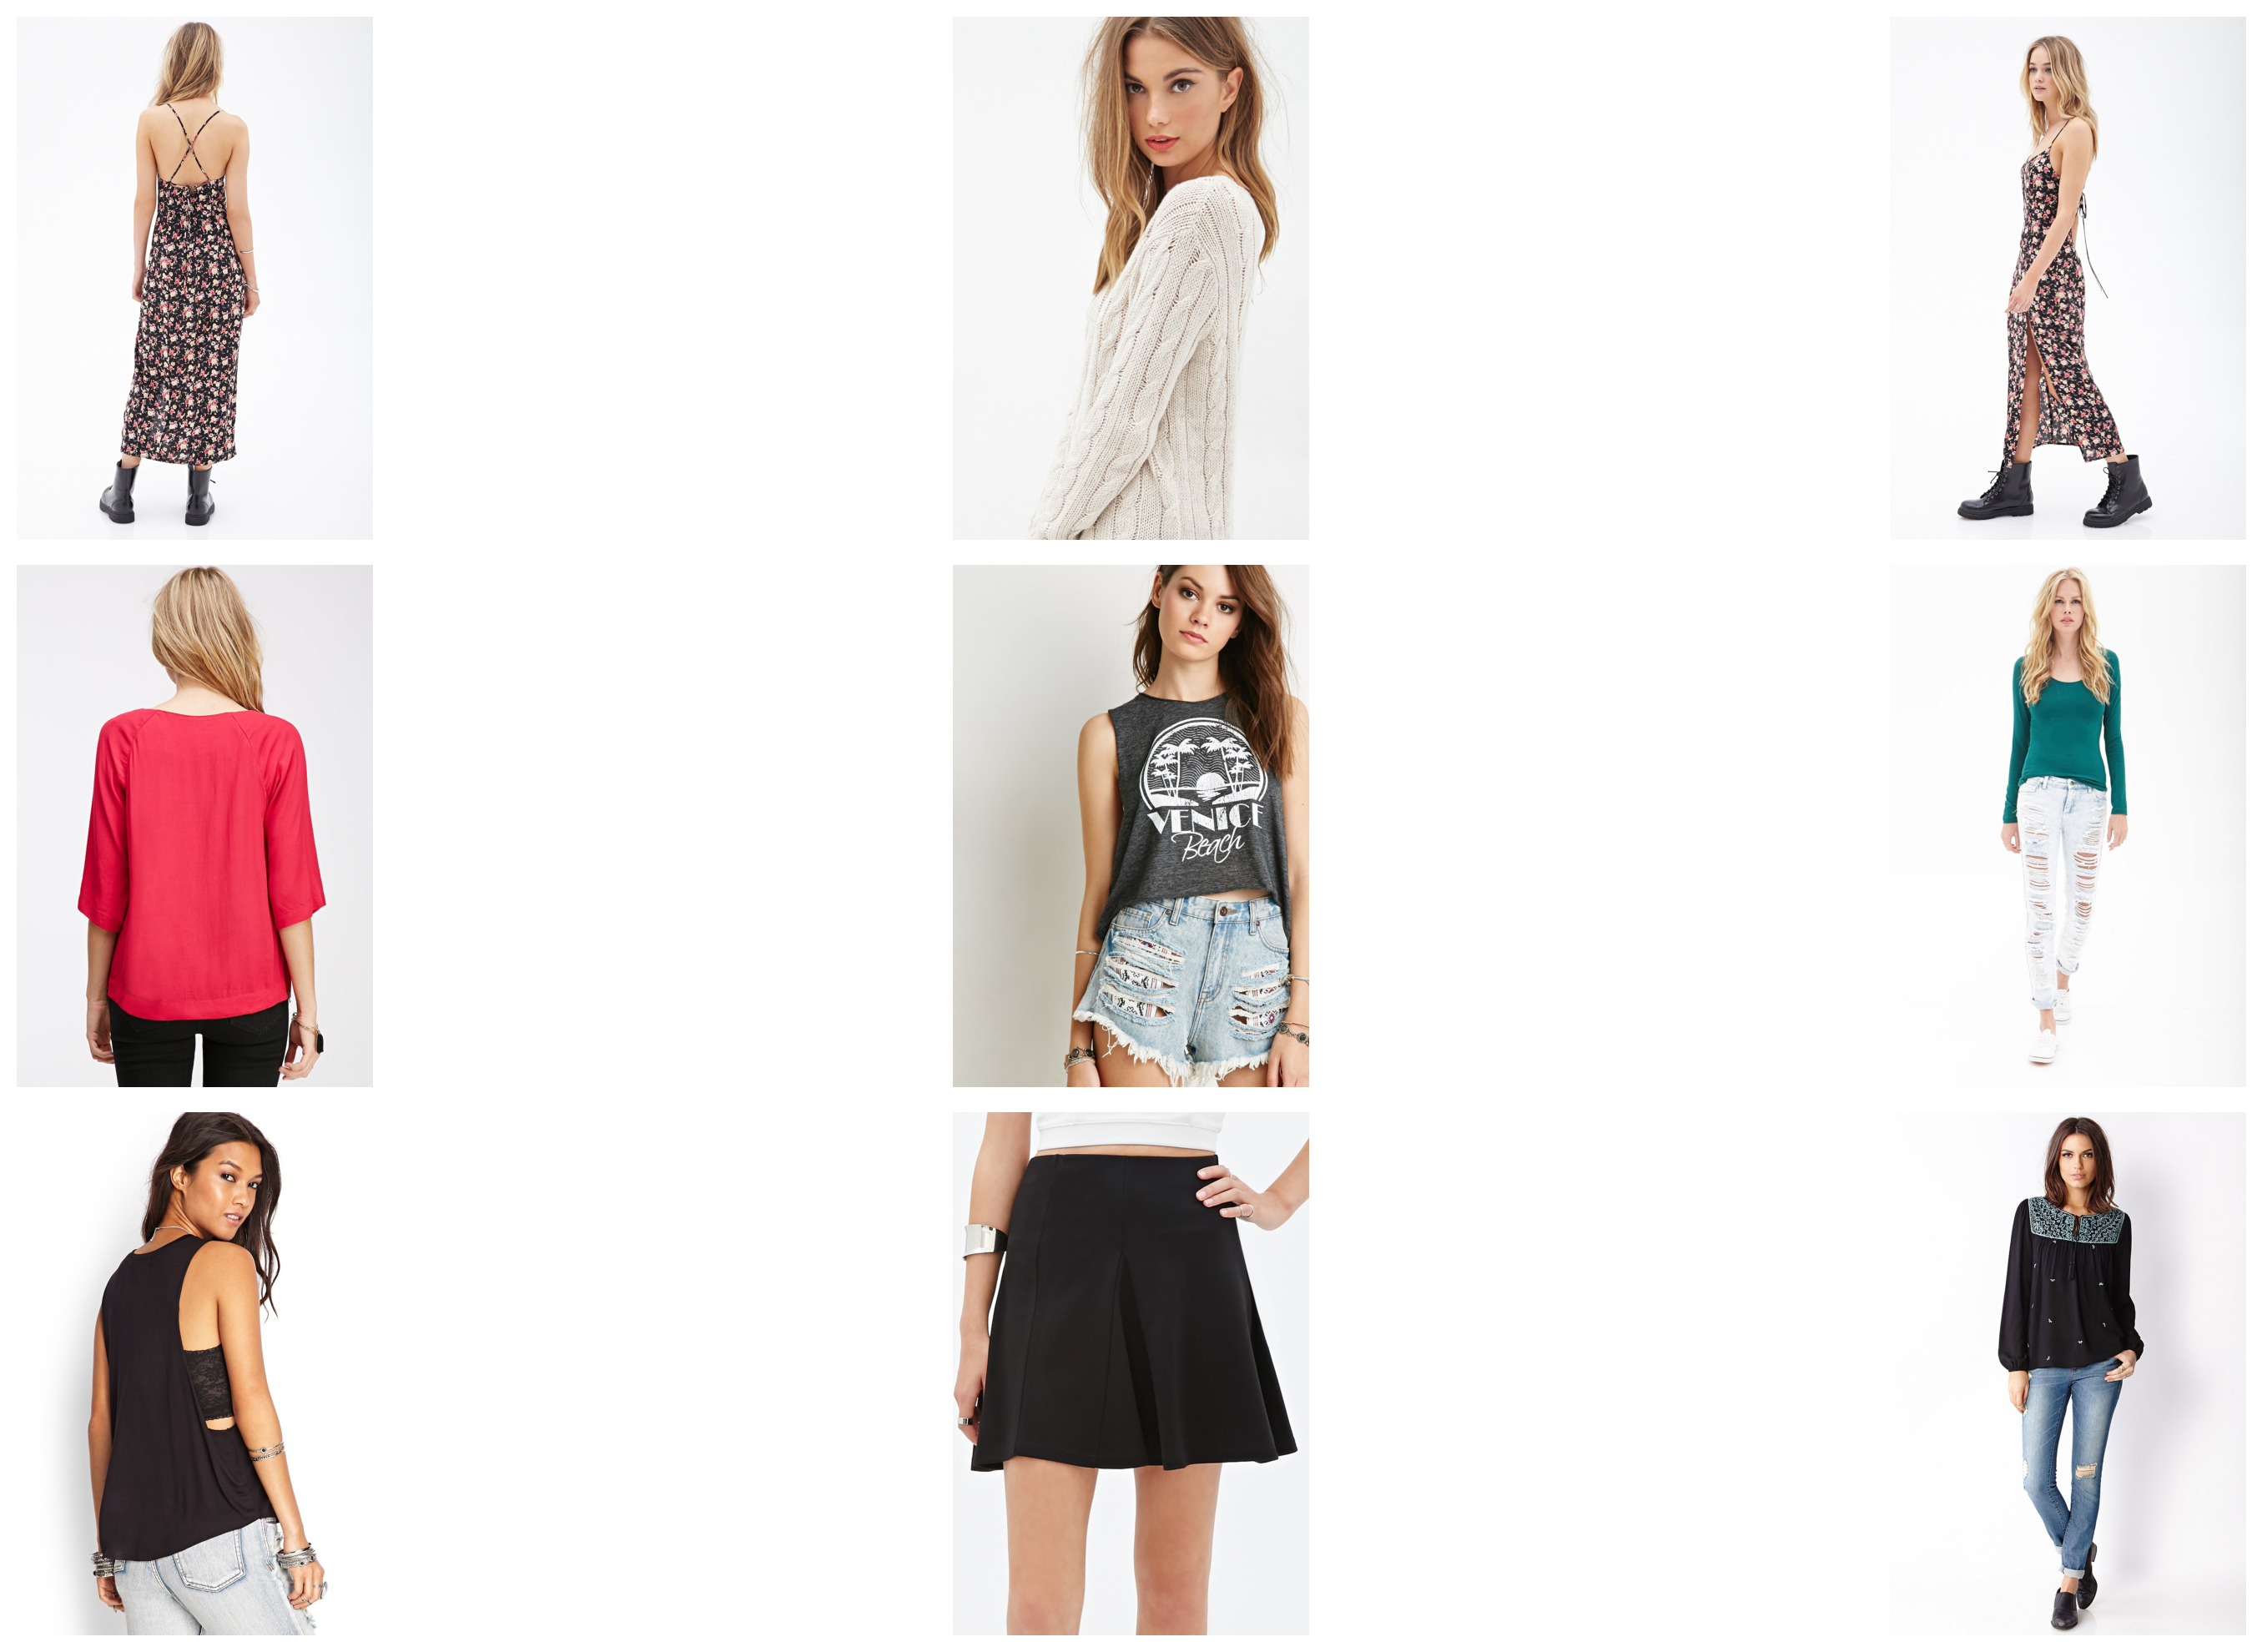

In [148]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def fix_path(p):
    # Lấy tên tệp tin
    fn = str(p.name)
    
    # Kiểm tra xem p có "WOMEN" hoặc "MEN" ở phần đầu hay không
    if p.parts[0] == "WOMEN":
        return Path("/kaggle/input/deepfashion1/WOMEN") / p  # Nếu là "WOMEN", thêm "WOMEN"
    elif p.parts[0] == "MEN":
        return Path("/kaggle/input/deepfashion1/MEN") / p  # Nếu là "MEN", thêm "MEN"
    else:
        return Path("/kaggle/input/deepfashion1") / p  # Trường hợp khác, giữ nguyên

# Hàm lấy ảnh và kết quả từ dataframe
def image_results(row, n=9):  # Change n to 9 for 9 images
    # 9 ảnh kết quả từ cột 'images' (cắt ra từ chuỗi)
    result_images = [Image.open(fix_path(Path(id))).convert("RGB") for id in row.images.split(' ')[:n]]

    return result_images

# Hàm để hiển thị các ảnh
def show_all(images, r=3, c=3, figsize=(20, 10)):  # Update r and c to fit 3 rows and 3 columns
    fig, axs = plt.subplots(r, c, figsize=figsize)  # Tạo lưới subplots (3 rows, 3 columns)
    axs = axs.flatten()  # Chuyển thành mảng 1 chiều để dễ thao tác

    # Duyệt qua và hiển thị các ảnh
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')  # Tắt hiển thị trục của ảnh

    plt.tight_layout()  # Căn chỉnh các ảnh hợp lý
    plt.show()

# Ví dụ sử dụng show_all với dataframe
# Hiển thị ảnh của row thứ 11 trong dataframe sub_df, bỏ qua ảnh query (ảnh đầu tiên)
show_all(image_results(sub_df.iloc[7]), r=3, c=3, figsize=(20, 10))
